In [2]:
import numpy as np

import matplotlib  #ploting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

import sys
sys.path.insert(0, "/data/rowe/python/ifort/") #pre-compiled Fortran library for python.

import binmodels_py as bm #Fortran routine for speedy resampling of data
#to generate binmodels_py with ifort
#f2py3 -c binmodels_py.pyf binmodels_py.f90 precision.f90 --fcompiler=intelem

#constants
c = 2.998e8 #speed of light (m/s)
h = 6.626e-34 #Planck m^2 kg/s
Pi= np.pi*1.0 #define Pi
Rsun=695700000.0  # Radius of Sun (m)

In [3]:
#generic routine to read in files
def readfile(filename):
    
    data=[]
    f=open(filename)
    icount=-1
    for line in f:
        line = line.strip()
        columns = line.split() #break into columns
        icount+=1
        if(icount > 0):  #skip header info
            data.append([float(i) for i in columns])
            #data.append(columns)
    f.close()
    
    return data

In [4]:
def readstarmodel(starmodel_file, nmodeltype, quiet=False):
    """Usage: starmodel_wv,starmodel_flux=readstarmodel(starmodel_file,smodeltype)
    Inputs:
      starmodel_file - full path and filename to star spectral model
      smodeltype - type of model.  2==ATLAS

    Returns:
      starmodel_wv : wavelength (A)
      starmodel_flux : flux
      ld_coeff : non-linear limb-darkening coefficients
    """
    if not quiet: print('Reading star model atmosphere {:}'.format(starmodel_file))

    starmodel_wv=[]
    starmodel_flux=[]
    ld_coeff=[]

    if nmodeltype==2:

        f = open(starmodel_file,'r')
        for line in f:
            line = line.strip() #get rid of \n at the end of the line
            columns = line.split() #break into columns with space delimiter
            wv=float(columns[0])
            starmodel_wv.append(wv/10)
            flux=-float(columns[5])*np.pi*(42.0*float(columns[1])+70.0*float(columns[2])\
                    +90.0*float(columns[3])+105.0*float(columns[4])-210.0)/210.0
            starmodel_flux.append(np.max([0.0,flux]))
            ld_coeff.append([float(columns[1]),float(columns[2]),float(columns[3])\
                ,float(columns[4])])
        f.close()

        starmodel_wv=np.array(starmodel_wv)
        starmodel_flux=np.array(starmodel_flux)
        ld_coeff=np.array(ld_coeff)

    else:
        print('Currently on ATLAS-9 models are supported (nmodeltype=2)')

    return starmodel_wv,starmodel_flux,ld_coeff;

def resample_models(dw,wv1,wv2,starmodel_wv,starmodel_flux,ld_coeff,\
    planetmodel_wv,planetmodel_rprs):
    """Resamples star and planet model onto common grid.

    Usage:
    bin_starmodel_wv,bin_starmodel_flux,bin_ld_coeff,bin_planetmodel_wv,bin_planetmodel_rprs\
      =resample_models(dw,starmodel_wv,starmodel_flux,ld_coeff,\
      planetmodel_wv,planetmodel_rprs,pars,tracePars)


      Inputs:
        dw - wavelength spacing.  This should be calculated using get_dw
        wv1 - short-wavelength start
        wv2 - long-wavelength stop
        starmodel_wv - stellar model wavelength array
        starmodel_flux - stellar model flux array
        ld_coeff - non-linear limb-darkening coefficients array
        planetmodel_wv - planet model wavelength array
        planetmodel_rprs - planet model Rp/R* array

      Output:
        bin_starmodel_wv - binned star wavelength array
        bin_starmodel_flux - binned star model array
        bin_ld_coeff - binned limb-darkening array
        bin_planetmodel_wv - binned planet wavelength array (should be same size as bin_starmodel_wv)
        bin_planetmodel_rprs - binned Rp/R* array
    """

    bmax=int((wv2-wv1)/dw)

    snpt=starmodel_wv.shape[0]
    pnpt=planetmodel_wv.shape[0]

    ld_coeff_in=np.zeros((snpt,4))

    bin_starmodel_wv=np.zeros(bmax)
    bin_starmodel_flux=np.zeros(bmax)
    bin_ld_coeff=np.zeros((bmax,4),order='F')
    bin_planetmodel_wv=np.zeros(bmax)
    bin_planetmodel_rprs=np.zeros(bmax)

    bm.binmodels_py(wv1,wv2,dw,\
        starmodel_wv,starmodel_flux,ld_coeff,\
        planetmodel_wv,planetmodel_rprs,\
        bin_starmodel_wv,bin_starmodel_flux,bin_ld_coeff,bin_planetmodel_wv,bin_planetmodel_rprs)

    # Make sure the array is sorted in increasing wavelengths
    ind = np.argsort(bin_starmodel_wv)
    bin_starmodel_wv = bin_starmodel_wv[ind]
    bin_starmodel_flux = bin_starmodel_flux[ind]
    bin_planetmodel_wv = bin_planetmodel_wv[ind]
    bin_planetmodel_rprs = bin_planetmodel_rprs[ind]
    bin_ld_coeff = bin_ld_coeff[ind]

    return bin_starmodel_wv,bin_starmodel_flux,bin_planetmodel_wv,bin_planetmodel_rprs

def read_pmodel(modelfile):
    pmodel_wv=[]
    pmodel_df=[]
    f = open(modelfile, 'r')
    for line in f:
        line = line.strip() #get rid of the \n at the end of the line
        line = line.split()
        if line[0][0]!='#':
            #print(line)
            pmodel_wv.append(float(line[0])*1000) #convert to A
            pmodel_df.append(float(line[1]))
    f.close()

    pmodel_wv=np.array(pmodel_wv)
    pmodel_df=np.array(pmodel_df)
    
    return pmodel_wv, pmodel_df

In [5]:
#Parameters
rstar=0.5      #Stellar radius (rstar)
rpl=58337/2    #planet radius
starmodel_file='/data/rowe/POET/ATLAS/t3500g500p000_ldnl.dat'
pmodel_file='/data/rowe/POET/PSG/GJ3470b/psg_ch4em4_haze_100_006.txt'
wv1=200   #Wavelength start -- range of spectra to use
wv2=1000  #Wavelength end
dw=1.0     #Resolution of resampled spectra


apmag_g = 11.35  #Apparent magnitude
aper=0.30      #Telescope aperture (m)
tput = 0.18    #system throughput (cumulative) to match real numbers from MOST
gain = 6.1     #Gain e-/ADU
fullwell = np.floor(gain*2.0**14) #full-well (e-)
exptime = 1.0  #integration time (secs)
psf_fwhm=1.5   #fwhm of psf (pixels)

#g filter
filter_cen=480
filter_width=98.8

#AB flux and zero point
abflux=3631.0e-26*3.0e8/(filter_cen*filter_cen*1.0e-18)
zcal=14.84 #Zero point to roughly calibrate our synthetic model against AB values for the Sun.

In [7]:
#Read in star spectrum
starmodel_wv,starmodel_flux,ld_coeff=readstarmodel(starmodel_file, nmodeltype=2)
starmodel_flux=starmodel_flux*rstar*rstar 
pmodel_wv, pmodel_rp = read_pmodel(pmodel_file)
pmodel_rp=(pmodel_rp+rpl)*1000 #convert atmosphere thickness to Rp

#Resample Spectra
bin_starmodel_wv,bin_starmodel_flux,bin_planetmodel_wv,bin_planetmodel_rp=resample_models(dw,wv1,wv2,starmodel_wv,starmodel_flux,ld_coeff,\
    pmodel_wv,pmodel_rp)

Reading star model atmosphere /data/rowe/POET/ATLAS/t3500g500p000_ldnl.dat


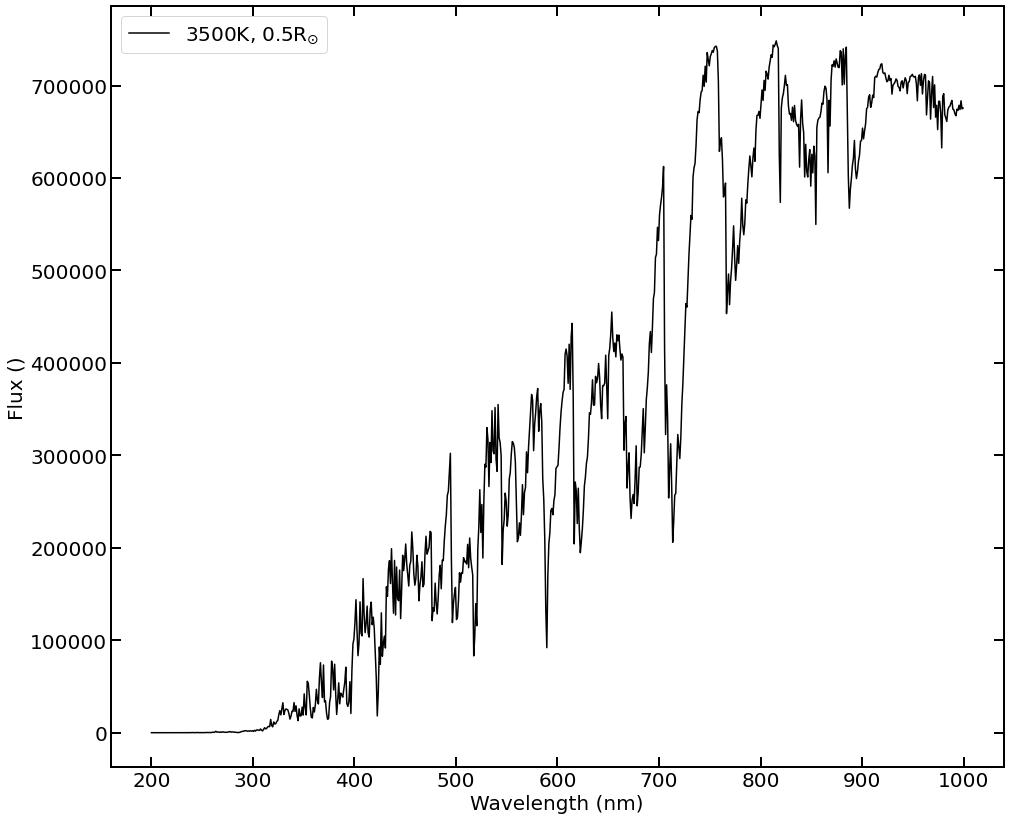

In [8]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig=plt.figure(figsize=(16,14)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2)
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Flux ()')

#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)

ax.plot(bin_starmodel_wv,bin_starmodel_flux,c='black',label='3500K, 0.5R$_{\odot}$')

ax.legend(fontsize=20,loc='upper left')

fig.show()

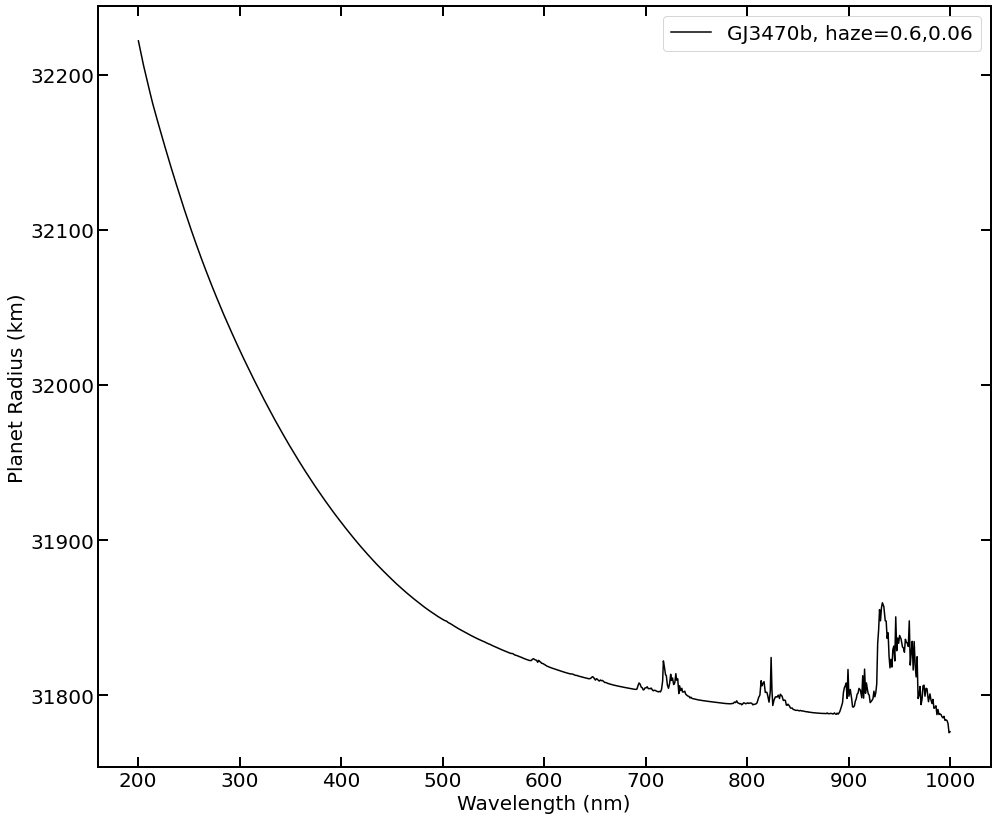

In [9]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig=plt.figure(figsize=(16,14)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2)
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Planet Radius (km)')

#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)

ax.plot(bin_planetmodel_wv,bin_planetmodel_rp/1000,c='black',label='GJ3470b, haze=0.6,0.06')

ax.legend(fontsize=20,loc='upper right')

fig.show()

Apparent, Abs_mag 11.35 9.298039442745498
Distance (pc) 25.72717563937587


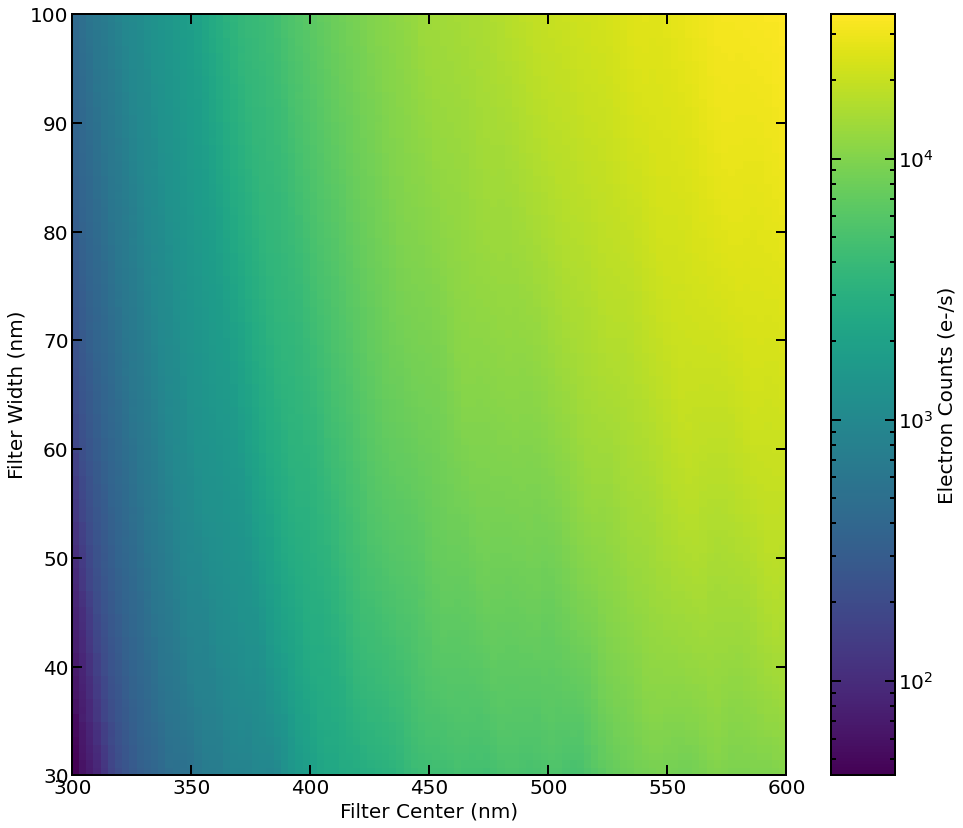

In [10]:
zcal=25.742

matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig=plt.figure(figsize=(16,14)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2)
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2)

    
ax.set_xlabel('Filter Center (nm)')
ax.set_ylabel('Filter Width (nm)')

cmap = plt.get_cmap('viridis')

w1=filter_cen-filter_width/2
w2=filter_cen+filter_width/2
fsum=np.sum(bin_starmodel_flux[(bin_starmodel_wv>w1)&(bin_starmodel_wv<w2)])
fsum=fsum/len(bin_starmodel_flux[(bin_starmodel_wv>w1)&(bin_starmodel_wv<w2)])

zmag=zcal-2.5*np.log10(fsum/abflux)

print('Apparent, Abs_mag',apmag_g,zmag)

distpc=10.0*10.0**((apmag_g-zmag)/5.0)
print('Distance (pc)', distpc)


nbin=100
img=np.ones((nbin,nbin))
x_axis=np.linspace(300,600,nbin)
y_axis=np.linspace(30,100,nbin)
i=-1
for fcen in x_axis:
    i+=1
    j=-1
    for fwid in y_axis:
        j+=1
        w1=fcen-fwid/2
        w2=fcen+fwid/2
        fsum=np.sum(bin_starmodel_flux[(bin_starmodel_wv>w1)&(bin_starmodel_wv<w2)])
        fsum=fsum/len(bin_starmodel_flux[(bin_starmodel_wv>w1)&(bin_starmodel_wv<w2)])
        
        zmag1=zcal-2.5*np.log10(fsum/abflux)
        
        colour=zmag1-zmag

        ener_phot=h*c/(fcen*1.0e-9) #use E=hv to get energy for one photon
        apmag=apmag_g+colour        #apparent mag in each filter
        F_obs = abflux*10.0e0**(apmag/-2.5)*fwid*1.0e-9*Pi*aper*aper #Flux * dlam * pi * aper^2
        photsec = F_obs/ener_phot*tput #e-/sec that reach the detector.
        
        img[j,i]+=photsec

vmin=np.min(img)
vmax=np.max(img)
im=ax.pcolormesh(x_axis,y_axis,img,zorder=1, norm=LogNorm(), cmap=cmap, \
                     vmin=vmin,vmax=vmax)

cbar=fig.colorbar(im, ax=ax, aspect=12)#, ticks=v1)
#cbar.ax.set_yticklabels(["{:4.0f}".format(i) for i in v1])
cbar.ax.tick_params(direction='in', which='major', length=10, width=2,left=True, right=True)
cbar.ax.tick_params(direction='in', which='minor', length=5, width=2,left=True, right=True)
cbar.set_label('Electron Counts (e-/s)')

fig.show()

Apparent, Abs_mag 11.35 9.298039442745498
Distance (pc) 25.72717563937587


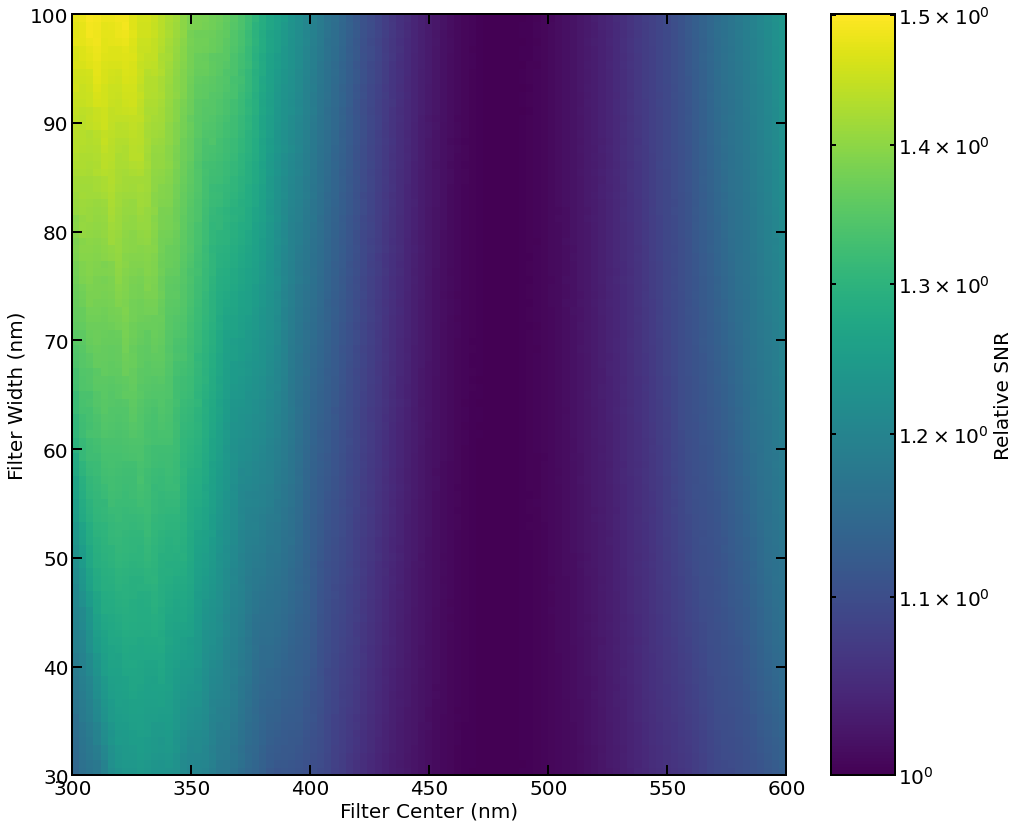

In [11]:
zcal=25.742

matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig=plt.figure(figsize=(16,14)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2)
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2)

    
ax.set_xlabel('Filter Center (nm)')
ax.set_ylabel('Filter Width (nm)')

cmap = plt.get_cmap('viridis')

w1=filter_cen-filter_width/2
w2=filter_cen+filter_width/2
fsum=np.sum(bin_starmodel_flux[(bin_starmodel_wv>w1)&(bin_starmodel_wv<w2)])
fsum=fsum/len(bin_starmodel_flux[(bin_starmodel_wv>w1)&(bin_starmodel_wv<w2)])

zmag=zcal-2.5*np.log10(fsum/abflux)

print('Apparent, Abs_mag',apmag_g,zmag)

distpc=10.0*10.0**((apmag_g-zmag)/5.0)
print('Distance (pc)', distpc)

wv1=600
wv2=1000
TESS_rprs=np.mean(bin_planetmodel_rp[(bin_planetmodel_wv>w1)&(bin_planetmodel_wv<w2)])/(rstar*Rsun)
dF_tess=TESS_rprs*TESS_rprs

nbin=100
img=np.ones((nbin,nbin))
x_axis=np.linspace(300,600,nbin)
y_axis=np.linspace(30,100,nbin)
i=-1
for fcen in x_axis:
    i+=1
    j=-1
    for fwid in y_axis:
        j+=1
        w1=fcen-fwid/2
        w2=fcen+fwid/2
        fsum=np.sum(bin_starmodel_flux[(bin_starmodel_wv>w1)&(bin_starmodel_wv<w2)])
        fsum=fsum/len(bin_starmodel_flux[(bin_starmodel_wv>w1)&(bin_starmodel_wv<w2)])
        
        rprs_avg= np.mean(bin_planetmodel_rp[(bin_planetmodel_wv>w1)&(bin_planetmodel_wv<w2)])/(rstar*Rsun)
        
        zmag1=zcal-2.5*np.log10(fsum/abflux)
        
        colour=zmag1-zmag

        ener_phot=h*c/(fcen*1.0e-9) #use E=hv to get energy for one photon
        apmag=apmag_g+colour        #apparent mag in each filter
        F_obs = abflux*10.0e0**(apmag/-2.5)*fwid*1.0e-9*Pi*aper*aper #Flux * dlam * pi * aper^2
        photsec = F_obs/ener_phot*tput #e-/sec that reach the detector.
        
        photsec=photsec*1.0e10
        
        #img[j,i]+=photsec
        #img[j,i]+=photsec*(1-np.abs(rprs_avg*rprs_avg-TESS_rprs*TESS_rprs))/np.sqrt(photsec)
        img[j,i]+=photsec*(rprs_avg-TESS_rprs)*(rprs_avg-TESS_rprs)/np.sqrt(photsec)
        #img[j,i]+=(rprs_avg-TESS_rprs)#*(rprs_avg-TESS_rprs)
        #img[j,i]=rprs_avg*1

img=img/np.min(img)
vmin=np.min(img)
vmax=np.max(img)
im=ax.pcolormesh(x_axis,y_axis,img,zorder=1, norm=LogNorm(), cmap=cmap, \
                     vmin=vmin,vmax=vmax)

cbar=fig.colorbar(im, ax=ax, aspect=12)#, ticks=v1)
#cbar.ax.set_yticklabels(["{:4.0f}".format(i) for i in v1])
cbar.ax.tick_params(direction='in', which='major', length=10, width=2,left=True, right=True)
cbar.ax.tick_params(direction='in', which='minor', length=5, width=2,left=True, right=True)
cbar.set_label('Relative SNR')

fig.show()

In [12]:
wv1=600
wv2=1000
TESS_rprs=np.mean(bin_planetmodel_rp[(bin_planetmodel_wv>w1)&(bin_planetmodel_wv<w2)])/(rstar*Rsun)
print(TESS_rprs)

0.09147581592065547


Apparent, Abs_mag 11.35 9.298039442745498
Distance (pc) 25.72717563937587


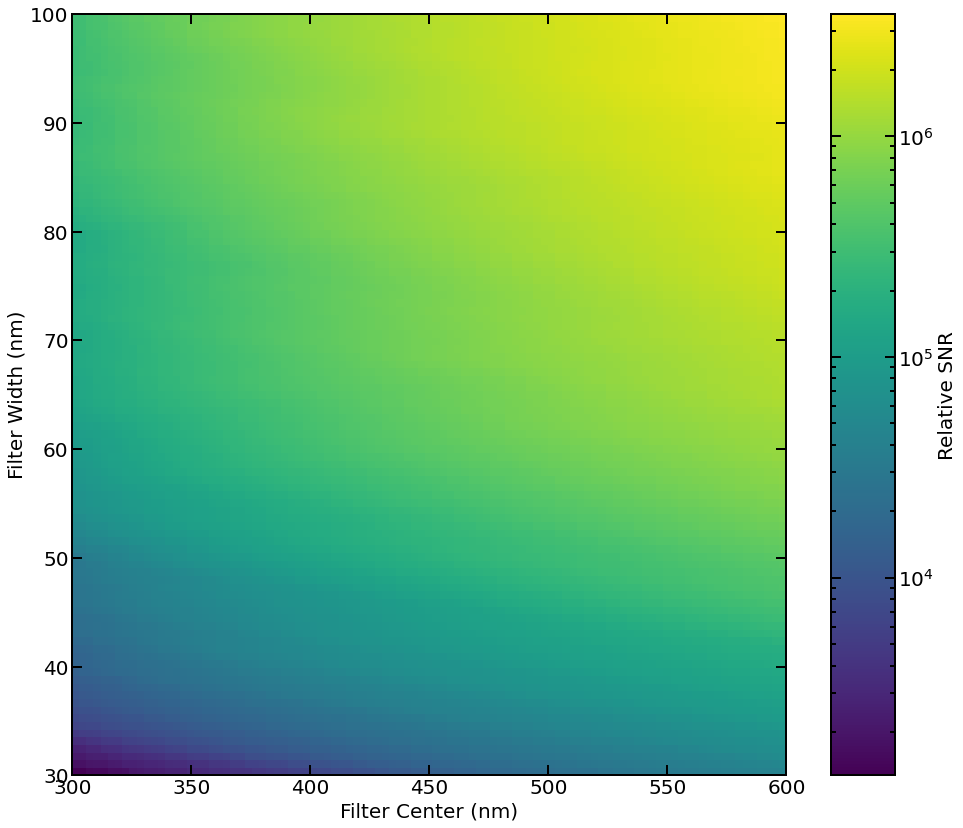

In [13]:
zcal=25.742

matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig=plt.figure(figsize=(16,14)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2)
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2)

    
ax.set_xlabel('Filter Center (nm)')
ax.set_ylabel('Filter Width (nm)')

cmap = plt.get_cmap('viridis')

w1=filter_cen-filter_width/2
w2=filter_cen+filter_width/2
fsum=np.sum(bin_starmodel_flux[(bin_starmodel_wv>w1)&(bin_starmodel_wv<w2)])
fsum=fsum/len(bin_starmodel_flux[(bin_starmodel_wv>w1)&(bin_starmodel_wv<w2)])

zmag=zcal-2.5*np.log10(fsum/abflux)

print('Apparent, Abs_mag',apmag_g,zmag)

distpc=10.0*10.0**((apmag_g-zmag)/5.0)
print('Distance (pc)', distpc)


wv1=600
wv2=1000
TESS_rprs=np.mean(bin_planetmodel_rp[(bin_planetmodel_wv>w1)&(bin_planetmodel_wv<w2)])/(rstar*Rsun)
dF_tess=TESS_rprs*TESS_rprs

nbin=100
img=np.ones((nbin,nbin))
x_axis=np.linspace(300,600,nbin)
y_axis=np.linspace(30,100,nbin)
i=-1
for fcen in x_axis:
    i+=1
    j=-1
    for fwid in y_axis:
        j+=1
        w1=fcen-fwid/2
        w2=fcen+fwid/2
        fsum=np.sum(bin_starmodel_flux[(bin_starmodel_wv>w1)&(bin_starmodel_wv<w2)])
        #fsum=fsum/len(bin_starmodel_flux[(bin_starmodel_wv>w1)&(bin_starmodel_wv<w2)])
        
        zmag1=zcal-2.5*np.log10(fsum/abflux)
        
        colour=zmag1-zmag

        ener_phot=h*c/(fcen*1.0e-9) #use E=hv to get energy for one photon
        apmag=apmag_g+colour        #apparent mag in each filter
        F_obs = abflux*10.0e0**(apmag/-2.5)*fwid*1.0e-9*Pi*aper*aper #Flux * dlam * pi * aper^2
        photsec = F_obs/ener_phot*tput #e-/sec that reach the detector.
        
        rprs_avg= np.mean(bin_planetmodel_rp[(bin_planetmodel_wv>w1)&(bin_planetmodel_wv<w2)])/(rstar*Rsun)
        #print(TESS_rprs,rprs_avg,np.abs(rprs_avg*rprs_avg-TESS_rprs*TESS_rprs))
        #input()
        img[i,j]+=photsec
        #img[i,j]+=np.abs(rprs_avg*rprs_avg-TESS_rprs*TESS_rprs)
        #img[i,j]+=photsec*(1-np.abs(rprs_avg*rprs_avg-TESS_rprs*TESS_rprs))/np.sqrt(photsec)

#img=img
vmin=np.min(img)
vmax=np.max(img)
im=ax.pcolormesh(x_axis,y_axis,img,zorder=1, norm=LogNorm(), cmap=cmap, \
                     vmin=vmin,vmax=vmax)

cbar=fig.colorbar(im, ax=ax, aspect=12)#, ticks=v1)
#cbar.ax.set_yticklabels(["{:4.0f}".format(i) for i in v1])
cbar.ax.tick_params(direction='in', which='major', length=10, width=2,left=True, right=True)
cbar.ax.tick_params(direction='in', which='minor', length=5, width=2,left=True, right=True)
cbar.set_label('Relative SNR')

fig.show()

In [14]:
ener_phot=h*c/(filter_cen*1.0e-9) #use E=hv to get energy for one photon
apmag=apmag_g+0        #apparent mag in each filter
F_obs = abflux*10.0e0**(apmag/-2.5)*filter_width*1.0e-9*Pi*aper*aper #Flux * dlam * pi * aper^2
photsec = F_obs/ener_phot*tput #e-/sec that reach the detector.
print(photsec)

16567.044470902238
